# NeuroM Tutorial Notebook

NeuroM contains helper functions that allow to easily load neuronal morphologies from files into NeuroM data structures. It also provides convenient methods to query various properties of the morphologies, as well as an easy way to visualize morphological objects.

In [3]:
%matplotlib inline


# Import neurom module
import neurom as nm
# Import neurom visualization module
from neurom.view import matplotlib_impl, matplotlib_utils, plotly_impl

## 1. Loading a morphology or a population

NeuroM can load morphologies from swc, h5 or NL ascii files. Please note that the Neurolucida ascii reader is experimental! There are no guarantees regarding correctness of loading data from files in this format.

In [ ]:
import morphio
morphio.set_raise_warnings(True)

In [4]:
# Load a single morphology  
neuron = nm.load_morphology('DNa02_clean.swc')
# neuron = nm.load_morphology('Neuron.swc')


# Load a population of morphologies from a set of files
# pop = nm.load_morphologies('../tests/data/valid_set/')

## 2. Morphology visualization

In [ ]:
# Visualize a morphology in two dimensions
fig, ax = plotly_impl.plot_morph(neuron, plane='xy', inline=True)

In [ ]:
# Visualize a morphology in three dimensions
fig, ax = plotly_impl.plot_morph3d(neuron, inline=True)

In [ ]:
# Visualize a single tree in three dimensions
fig, ax = plotly_impl.plot_morph3d(neuron.neurites[0], inline=True)

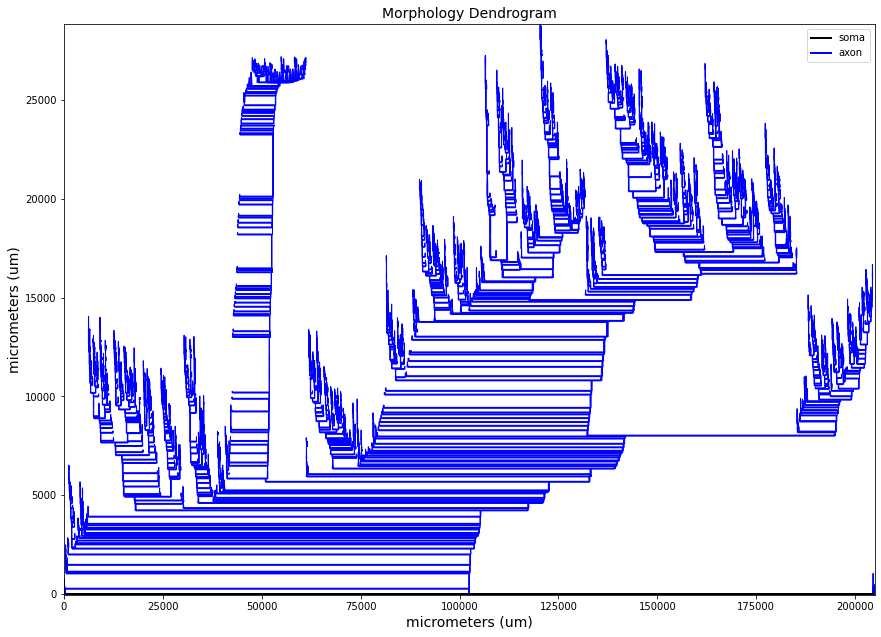

In [5]:
# Visualize the dendrogram of a morphology
fig, ax = matplotlib_utils.get_figure()

matplotlib_impl.plot_dendrogram(neuron, ax)
matplotlib_utils.plot_style(fig=fig, ax=ax)

fig.set_size_inches(18.5, 10.5)
ax.set_aspect(5)

## 3. Morphology analysis

### 3.1 Morphometrics extraction

In [ ]:
# Extract the total number of neurites (basal and apical dendrites, and axons)
number_of_neurites = nm.get('number_of_neurites', neuron)

# Extract the total number of sections
number_of_sections = nm.get('number_of_sections', neuron)

# Extract the soma radius
soma_radius = neuron.soma.radius

# Extract the number of sections per neurite
number_of_sections_per_neurite = nm.get('number_of_sections_per_neurite', neuron)

# Print result
print("Morphology id          : {0} \n\
Number of neurites : {1} \n\
Soma radius        : {2:.2f} \n\
Number of sections : {3}".format(neuron.name, number_of_neurites, soma_radius, number_of_sections))
print()
print("Neurite type \t\t\t| Number of sections")
for i, neurite in enumerate(neuron.neurites):    
    print("{0:31} | {1}".format(str(neurite.type), number_of_sections_per_neurite[i]))

In [ ]:
# Extract the lengths of the sections
section_lengths = nm.get('section_lengths', neuron)

# Extract the lengths of the segments
segment_lengths = nm.get('segment_lengths', neuron)

# Extract the local bifurcation angles
local_bif_angles = nm.get('local_bifurcation_angles', neuron)

# Extract the remote bifurcation angles
remote_bif_angles = nm.get('remote_bifurcation_angles', neuron)

# Extract the radial distances of the sections
section_radial_distances = nm.get('section_radial_distances', neuron)

# Extract the path distances of the sections
section_path_distances = nm.get('section_path_distances', neuron)

# Print result
features = (segment_lengths, section_lengths, local_bif_angles, 
            remote_bif_angles, section_path_distances, section_radial_distances)

def check(feature_list, n): 
    return '{0:.2f}'.format(feature_list[n]) if n < len(feature_list) else ''

print('|sg_len|sc_len|lc_bif_angles|rm_bif_angles|sc_path_dists|sc_rad_dists|')
for n in range(0, 50):
    args = (check(f, n) for f in features)
    print('|{0:^6}|{1:^6}|{2:^13}|{3:^13}|{4:^13}|{5:^12}|'.format(*args))

### 3.2 Analyze different types of trees

The previous examples treated all neurites in the same way. NeuroM allows you to extract morphometrics for a selected type of trees.

In [ ]:
# Extract the section lengths of axonal trees
ax_section_lengths = nm.get('section_lengths', neuron, neurite_type=nm.AXON)

# Extract the section lengths of basal dendrite trees
ba_section_lengths = nm.get('section_lengths', neuron, neurite_type=nm.BASAL_DENDRITE)

# Extract the section lengths of apical dendrite trees
ap_section_lengths = nm.get('section_lengths', neuron, neurite_type=nm.APICAL_DENDRITE)

print('\nAxonal section lengths = ', ax_section_lengths)
print('\nBasal section lengths =  ', ba_section_lengths)
print('\nApical section lengths = ', ap_section_lengths)

### 3.3 Perform statistical analysis on extracted measurements

Now we are ready to extract basic statistical measurements, using common Python functions. For this, we will use [`numpy`](http://www.numpy.org/), which is a package for scientific computing with Python.

In [ ]:
import numpy as np

# We can get the mean section length
mean_sl = np.mean(section_lengths)

# We can get the standard deviation of the section lengths
std_sl = np.std(section_lengths)

# We can get the minimum section length
min_sl = np.min(section_lengths)

# ... and the maximum section length
max_sl = np.max(section_lengths)

print('Section length statistics:')
print('  [mean, std] = [{0:.2f}, {1:.2f}]'.format(mean_sl, std_sl))
print('  [min, max]: [{0:.2f}, {1:.2f}]'.format(min_sl, max_sl))

### 3.4 Generate plots from the extracted morphometrics

The distribution of the extracted measurements can be plotted with [`matplotlib`](http://matplotlib.org/), which is a Python library for plot generation. We will use the [`matplotlib.pyplot`](http://matplotlib.org/api/pyplot_api.html) sub module.

In [ ]:
import matplotlib.pyplot as plt

# Select the feature of choice
feature = nm.get('segment_lengths', neuron)

# Create empty figure
fig = plt.figure(figsize=(11,3))

# Create histogram
ax = fig.add_subplot('131')
ax.hist(feature, bins=25, edgecolor='black')

# Create cumulative histogram
ax = fig.add_subplot('132')
ax.hist(feature, bins=25, cumulative=True, edgecolor='black')

# Create boxplot; flier points are indicated with green dots
ax = fig.add_subplot('133')
_ = ax.boxplot(feature, sym='g.')

### 3.5 Fit the extracted data with a statistical distribution

Now we are ready to fit the extracted data using common Python functions. For this, we will use [`scipy`](http://www.scipy.org/), which is a package for numerical routines for scientific computing with Python.

In [ ]:
from neurom import stats

data = nm.get('segment_lengths', neuron)

# Let’s start with a normal distribution. We will fit the data that we extracted above with a normal distribution
p = stats.fit(data, distribution='norm')

# The output of the function is a named tuple of type FitResults
print('Fit output type : ', type(p))

# The parameters are stored in the variable params, which in the case of the normal distribution stores the mu and sigma
# of the normal distribution
mu, sigma = p.params
ks_dist, pvalue = p.errs

# Print result
print('[mu, sigma] : [{0:.2f}, {1:.2f}]\n'.format(mu, sigma))

# We need to check the statistical error of the performed fit to evaluate the accuracy of the 
# selected model. To do so we use the errors variable of FitResults:
print('Kolmogorov-Smirnov distance : {0:.2f}'.format(ks_dist))
print('P-value : {0:.2f}'.format(pvalue))

The result of the fitting can be visualized:

In [ ]:
from scipy.stats import norm

# Create a histogram as above
fig = plt.figure()
plt.hist(data, bins=25, density=True, edgecolor='black')

# Plot range: 5 standard deviations around the mean
norm_range = np.arange(mu - 5.*sigma, mu + 5.*sigma, 0.001)

# Plot the normal pdf with the given range, mu and sigma
_ = plt.plot(norm_range, norm.pdf(norm_range, mu, sigma), linewidth=3., c='r', alpha=0.8)

It is also possible to find the optimal distribution that best fits the data, among a number of distributions that are
supported by `scipy`:

In [ ]:
p = stats.optimal_distribution(data, distr_to_check=('lognorm', 'logistic', 'norm'))
print('Fit results:', p)

### 3.6 Apply more advanced manipulation on extracted data

In this example, we extract all section lengths that exceed a selected threshold.

In [ ]:
# Threshold value
threshold = 10

# Get the ids of sections which length exceeds the threshold
selected_ids = np.where(section_lengths > threshold)

# Get the values of section lengths that exceed the threshold
section_lengths[selected_ids]

### 3.7 Combine morphometrics

We can study relations between different morphometrics. For example, we can combine section length and path length to soma:

In [ ]:
# Get the length of all sections with a radial distance between 0.0 and 60.0
section_indices = np.where((section_radial_distances >= 0.0) & (section_radial_distances < 60.0))
selected_section_lengths = section_lengths[section_indices]
print(selected_section_lengths)